In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.datasets import mnist


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# For SSIM
!pip -q install scikit-image >/dev/null 2>&1
from skimage.metrics import structural_similarity as ssim

# Fix random seeds for reproducibility (optional)
import random
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

print("TensorFlow version:", tf.__version__)

# --- 1. Configurable parameters ---
DATASET = "MNIST"   # "MNIST" or "CIFAR10"
BATCH_SIZE = 128
EPOCHS = 30
LATENT_DIM = 64     # change to compress more/less
IMG_RESCALE = True  # scale images to [0,1]
USE_GPU = tf.config.list_physical_devices('GPU') != []

print("Using GPU:", USE_GPU)

TensorFlow version: 2.19.0
Using GPU: True


In [2]:
if DATASET == "MNIST":
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # MNIST shape: (N, 28, 28), grayscale
    x_train = np.expand_dims(x_train, -1)
    x_test  = np.expand_dims(x_test, -1)
    input_shape = x_train.shape[1:]  # (28,28,1)
else:
    # CIFAR-10 branch (uncomment import at top if switching)
    from tensorflow.keras.datasets import cifar10
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    y_train = y_train.flatten(); y_test = y_test.flatten()
    input_shape = x_train.shape[1:]  # (32,32,3)

print("Dataset:", DATASET, "| input shape:", input_shape)
print("Train / Test sizes:", x_train.shape[0], x_test.shape[0])


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Dataset: MNIST | input shape: (28, 28, 1)
Train / Test sizes: 60000 10000


In [3]:
if IMG_RESCALE:
    x_train = x_train.astype("float32") / 255.
    x_test  = x_test.astype("float32") / 255.
else:
    x_train = x_train.astype("float32")
    x_test  = x_test.astype("float32")


In [4]:
def build_conv_autoencoder(input_shape, latent_dim):
    inp = layers.Input(shape=input_shape)
    x = inp
    # Encoder
    x = layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')(x) # /2
    x = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(x) # /4
    # If input is 28x28 -> after two strided convs: 7x7 (approx)
    shape_before_flatten = tf.keras.backend.int_shape(x)[1:]  # (h,w,channels)
    x = layers.Flatten()(x)
    latent = layers.Dense(latent_dim, name='latent_vector')(x)

    # Decoder
    x = layers.Dense(np.prod(shape_before_flatten), activation='relu')(latent)
    x = layers.Reshape(shape_before_flatten)(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)  # *2
    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)  # *4
    # final conv to get original channels
    channels = input_shape[-1]
    x = layers.Conv2D(channels, 3, padding='same', activation='sigmoid')(x)

    encoder = models.Model(inp, latent, name="encoder")
    autoencoder = models.Model(inp, x, name="autoencoder")
    return encoder, autoencoder

encoder, autoencoder = build_conv_autoencoder(input_shape, LATENT_DIM)
autoencoder.summary()
encoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_vector (Dense)           │ (None, 64)             │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3136)           │       203,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 479,105 (1.83 MB)

 Trainable params: 479,105 (1.83 MB)

 Non-trainable params: 0 (0.00 B)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_vector (Dense)           │ (None, 64)             │       200,768 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 219,584 (857.75 KB)

 Trainable params: 219,584 (857.75 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
autoencoder.compile(optimizer=optimizers.Adam(1e-3), loss='mse', metrics=['mae'])
log_dir = f"/tmp/ae_logs_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
os.makedirs(log_dir, exist_ok=True)
cb = [
    callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    callbacks.ModelCheckpoint(os.path.join(log_dir, 'autoencoder_best.h5'), save_best_only=True, monitor='val_loss'),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

In [6]:
history = autoencoder.fit(
    x_train, x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_split=0.1,
    callbacks=cb
)

Epoch 1/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0774 - mae: 0.1625

422/422 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.0773 - mae: 0.1623 - val_loss: 0.0078 - val_mae: 0.0291 - learning_rate: 0.0010
Epoch 2/30
417/422 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0064 - mae: 0.0258

422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0064 - mae: 0.0258 - val_loss: 0.0042 - val_mae: 0.0204 - learning_rate: 0.0010
Epoch 3/30
415/422 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038 - mae: 0.0195

422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0038 - mae: 0.0194 - val_loss: 0.0032 - val_mae: 0.0179 - learning_rate: 0.0010
Epoch 4/30
417/422 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - mae: 0.0173

422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0030 - mae: 0.0173 - val_loss: 0.0028 - val_mae: 0.0166 - learning_rate: 0.0010
Epoch 5/30
418/422 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026 - mae: 0.0161

422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0026 - mae: 0.0160 - val_loss: 0.0025 - val_mae: 0.0157 - learning_rate: 0.0010
Epoch 6/30
416/422 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023 - mae: 0.0152

422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0023 - mae: 0.0152 - val_loss: 0.0023 - val_mae: 0.0150 - learning_rate: 0.0010
Epoch 7/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021 - mae: 0.0145

422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0021 - mae: 0.0145 - val_loss: 0.0021 - val_mae: 0.0145 - learning_rate: 0.0010
Epoch 8/30
421/422 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - mae: 0.0140

422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0020 - mae: 0.0140 - val_loss: 0.0020 - val_mae: 0.0140 - learning_rate: 0.0010
Epoch 9/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019 - mae: 0.0136

422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0019 - mae: 0.0136 - val_loss: 0.0020 - val_mae: 0.0139 - learning_rate: 0.0010
Epoch 10/30
420/422 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018 - mae: 0.0133

422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0018 - mae: 0.0133 - val_loss: 0.0019 - val_mae: 0.0135 - learning_rate: 0.0010
Epoch 11/30
419/422 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017 - mae: 0.0129

422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0017 - mae: 0.0129 - val_loss: 0.0019 - val_mae: 0.0134 - learning_rate: 0.0010
Epoch 12/30
419/422 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mae: 0.0127

422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0017 - mae: 0.0127 - val_loss: 0.0018 - val_mae: 0.0130 - learning_rate: 0.0010
Epoch 13/30
418/422 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mae: 0.0124

422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0016 - mae: 0.0124 - val_loss: 0.0018 - val_mae: 0.0127 - learning_rate: 0.0010
Epoch 14/30
414/422 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016 - mae: 0.0123

422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0016 - mae: 0.0123 - val_loss: 0.0017 - val_mae: 0.0126 - learning_rate: 0.0010
Epoch 15/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0016 - mae: 0.0122 - val_loss: 0.0018 - val_mae: 0.0127 - learning_rate: 0.0010
Epoch 16/30
415/422 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - mae: 0.0117

422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0015 - mae: 0.0117 - val_loss: 0.0016 - val_mae: 0.0122 - learning_rate: 5.0000e-04
Epoch 17/30
414/422 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014 - mae: 0.0115

422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0014 - mae: 0.0115 - val_loss: 0.0016 - val_mae: 0.0121 - learning_rate: 5.0000e-04
Epoch 18/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - mae: 0.0114

422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0014 - mae: 0.0114 - val_loss: 0.0016 - val_mae: 0.0120 - learning_rate: 5.0000e-04
Epoch 19/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - mae: 0.0113

422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0014 - mae: 0.0113 - val_loss: 0.0016 - val_mae: 0.0119 - learning_rate: 5.0000e-04
Epoch 20/30
416/422 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014 - mae: 0.0112

422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0014 - mae: 0.0112 - val_loss: 0.0015 - val_mae: 0.0118 - learning_rate: 2.5000e-04
Epoch 21/30
417/422 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - mae: 0.0111

422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0013 - mae: 0.0111 - val_loss: 0.0015 - val_mae: 0.0117 - learning_rate: 2.5000e-04
Epoch 22/30
421/422 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - mae: 0.0110

422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0013 - mae: 0.0110 - val_loss: 0.0015 - val_mae: 0.0117 - learning_rate: 2.5000e-04
Epoch 23/30
418/422 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - mae: 0.0109

422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0013 - mae: 0.0109 - val_loss: 0.0015 - val_mae: 0.0116 - learning_rate: 1.2500e-04
Epoch 24/30
418/422 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - mae: 0.0109

422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0013 - mae: 0.0109 - val_loss: 0.0015 - val_mae: 0.0116 - learning_rate: 1.2500e-04
Epoch 25/30
418/422 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - mae: 0.0109

422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0013 - mae: 0.0109 - val_loss: 0.0015 - val_mae: 0.0115 - learning_rate: 1.2500e-04
Epoch 26/30
415/422 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - mae: 0.0109

422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0013 - mae: 0.0109 - val_loss: 0.0015 - val_mae: 0.0115 - learning_rate: 1.2500e-04
Epoch 27/30
416/422 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - mae: 0.0108

422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0013 - mae: 0.0108 - val_loss: 0.0015 - val_mae: 0.0115 - learning_rate: 6.2500e-05
Epoch 28/30
421/422 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - mae: 0.0108

422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0013 - mae: 0.0108 - val_loss: 0.0015 - val_mae: 0.0115 - learning_rate: 6.2500e-05
Epoch 29/30
417/422 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - mae: 0.0108

422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0013 - mae: 0.0108 - val_loss: 0.0015 - val_mae: 0.0115 - learning_rate: 6.2500e-05
Epoch 30/30
419/422 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - mae: 0.0107

422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0013 - mae: 0.0107 - val_loss: 0.0015 - val_mae: 0.0114 - learning_rate: 3.1250e-05


In [7]:
x_test_pred = autoencoder.predict(x_test, batch_size=BATCH_SIZE)

# Metrics functions
def compute_mse(true, recon):
    return np.mean(np.square(true - recon), axis=(1,2,3))

def compute_mae(true, recon):
    return np.mean(np.abs(true - recon), axis=(1,2,3))

def compute_psnr_batch(true, recon, data_range=1.0):
    # data_range = 1.0 if inputs in [0,1]
    mse_vals = compute_mse(true, recon)
    # avoid divide by zero
    psnr_vals = 20 * np.log10(data_range) - 10 * np.log10(np.maximum(mse_vals, 1e-12))
    return psnr_vals

def compute_ssim_batch(true, recon):
    # skimage ssim expects 2D or multichannel images. Compute per-sample.
    ssim_vals = []
    for i in range(true.shape[0]):
        if true.shape[-1] == 1:
            # squeeze last channel
            t = np.squeeze(true[i], axis=-1)
            r = np.squeeze(recon[i], axis=-1)
            val = ssim(t, r, data_range=1.0)
        else:
            val = ssim(true[i], recon[i], multichannel=True, data_range=1.0)
        ssim_vals.append(val)
    return np.array(ssim_vals)

mse_vals = compute_mse(x_test, x_test_pred)
mae_vals = compute_mae(x_test, x_test_pred)
psnr_vals = compute_psnr_batch(x_test, x_test_pred, data_range=1.0)
ssim_vals = compute_ssim_batch(x_test, x_test_pred)

# Aggregate metrics
metrics_summary = {
    'MSE_mean': float(np.mean(mse_vals)),
    'MSE_std' : float(np.std(mse_vals)),
    'MAE_mean': float(np.mean(mae_vals)),
    'PSNR_mean': float(np.mean(psnr_vals)),
    'SSIM_mean': float(np.mean(ssim_vals))
}
print("=== Test set metrics summary ===")
for k,v in metrics_summary.items():
    print(f"{k}: {v:.6f}")


79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
=== Test set metrics summary ===
MSE_mean: 0.001407
MSE_std: 0.000898
MAE_mean: 0.011088
PSNR_mean: 29.322279
SSIM_mean: 0.983769


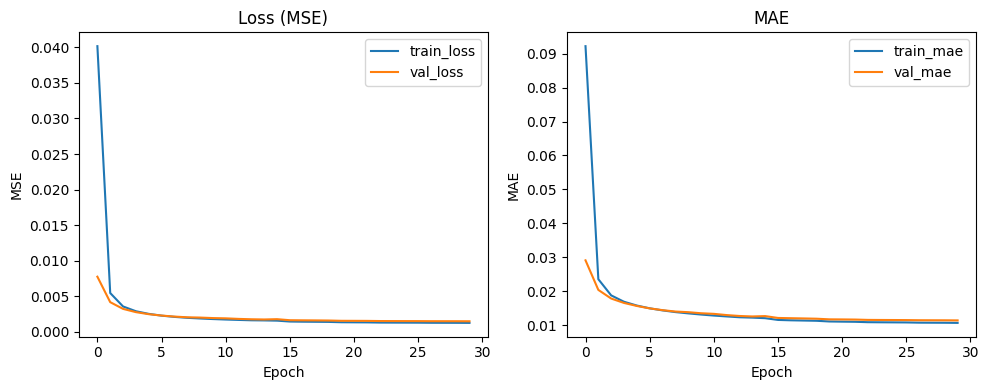

In [8]:
# 8.1 Training curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss (MSE)'); plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.title('MAE'); plt.xlabel('Epoch'); plt.ylabel('MAE'); plt.legend()
plt.tight_layout()
plt.show()

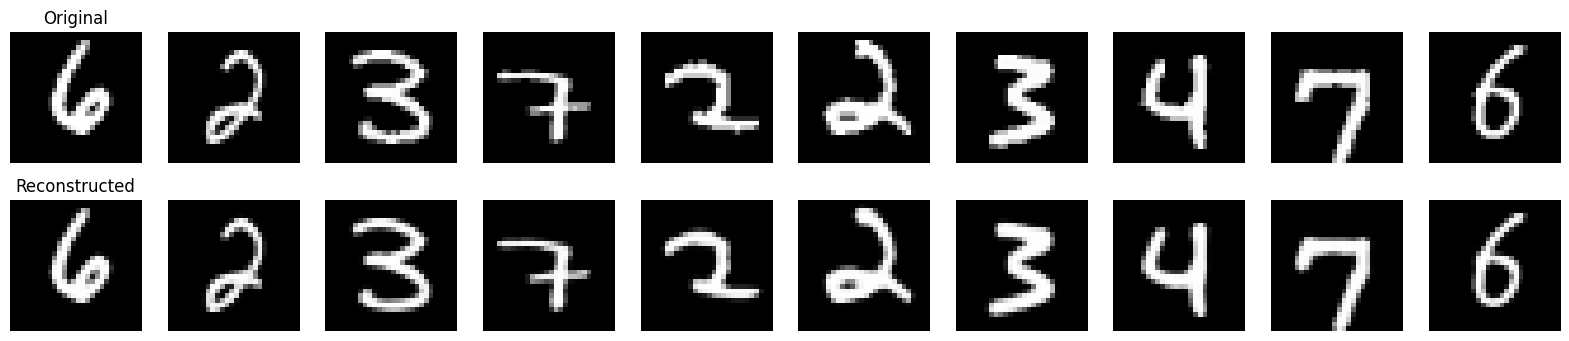

In [9]:
def plot_reconstructions(orig, recon, n=10):
    plt.figure(figsize=(2*n,4))
    for i in range(n):
        # original
        ax = plt.subplot(2, n, i+1)
        img = orig[i]
        if img.shape[-1] == 1:
            plt.imshow(img.squeeze(), cmap='gray')
        else:
            plt.imshow(img)
        ax.axis('off')
        if i == 0: ax.set_title("Original")

        # reconstruction
        ax = plt.subplot(2, n, n+i+1)
        imgr = recon[i]
        if img.shape[-1] == 1:
            plt.imshow(imgr.squeeze(), cmap='gray')
        else:
            plt.imshow(imgr)
        ax.axis('off')
        if i == 0: ax.set_title("Reconstructed")
    plt.show()

# pick random sample indices to show
idxs = np.random.choice(len(x_test), size=10, replace=False)
plot_reconstructions(x_test[idxs], x_test_pred[idxs], n=10)

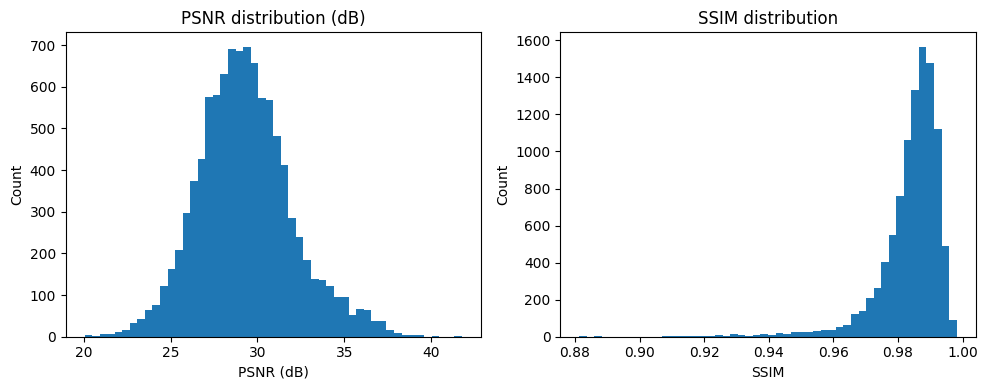

In [10]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(psnr_vals, bins=50)
plt.title("PSNR distribution (dB)")
plt.xlabel("PSNR (dB)"); plt.ylabel("Count")

plt.subplot(1,2,2)
plt.hist(ssim_vals, bins=50)
plt.title("SSIM distribution")
plt.xlabel("SSIM"); plt.ylabel("Count")
plt.tight_layout()
plt.show()

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


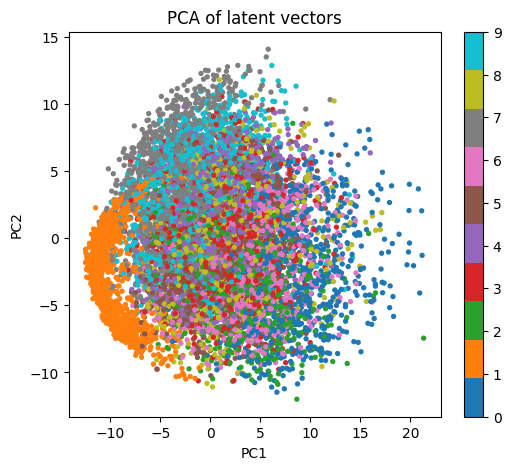

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


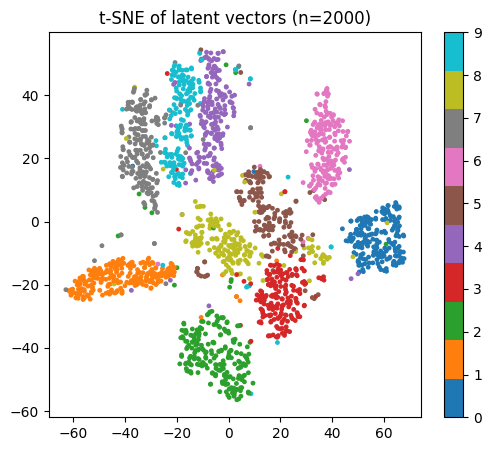

In [11]:
# Extract latent vectors for test set
latent_test = encoder.predict(x_test, batch_size=BATCH_SIZE)

# PCA to 2D
pca = PCA(n_components=2, random_state=SEED)
z_pca = pca.fit_transform(latent_test)

plt.figure(figsize=(6,5))
scatter = plt.scatter(z_pca[:,0], z_pca[:,1], c=y_test, s=8, cmap='tab10')
plt.title('PCA of latent vectors')
plt.colorbar(scatter, ticks=np.unique(y_test))
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.show()

# t-SNE (slower) - run on subset for speed if dataset large
subset = 2000
sel_idx = np.random.choice(len(latent_test), subset, replace=False)
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=SEED, init='pca')
z_tsne = tsne.fit_transform(latent_test[sel_idx])

plt.figure(figsize=(6,5))
plt.scatter(z_tsne[:,0], z_tsne[:,1], c=y_test[sel_idx], s=6, cmap='tab10')
plt.title(f't-SNE of latent vectors (n={subset})')
plt.colorbar()
plt.show()

In [12]:
# --- 10. Representation evaluation: train simple classifier on latent vectors ---
# Train logistic regression on latent space: use a subset to train
# We will use training partition latent vectors:
latent_train = encoder.predict(x_train, batch_size=BATCH_SIZE)

# Use a simple Logistic Regression (scikit-learn)
clf = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='saga')
# Random subsample for speed
sub_n = 5000 if latent_train.shape[0] > 5000 else latent_train.shape[0]
train_idx = np.random.choice(latent_train.shape[0], sub_n, replace=False)
clf.fit(latent_train[train_idx], y_train[train_idx])

# Evaluate on test latent vectors
y_pred = clf.predict(latent_test)
acc = accuracy_score(y_test, y_pred)
print(f"Logistic Regression on latent vectors - Accuracy: {acc*100:.2f}%")

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression on latent vectors - Accuracy: 90.78%
